In [1]:
import igraph as ig


track_network_path = "../network-parser/track_graph.graphml"
artist_network_path = "../network-parser/output/artist_graph.graphml"

# read graphml files
track_network = ig.Graph.Read_GraphML(track_network_path)
# artist_network = ig.Graph.Read_GraphML(artist_network_path)

# force convert to undirected
track_network.to_undirected()
# artist_network.to_undirected()

# force convert to simple
# track_network.simplify()
# artist_network.simplify()

# # confirm
# print(track_network.is_simple())
# print(artist_network.is_simple())

graph = track_network



# Plain Random Walk

Testing num_steps=1


Processing playlists:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 4.15%
Mean recommended degree: 817.76
Mean recommendation score: 0.00


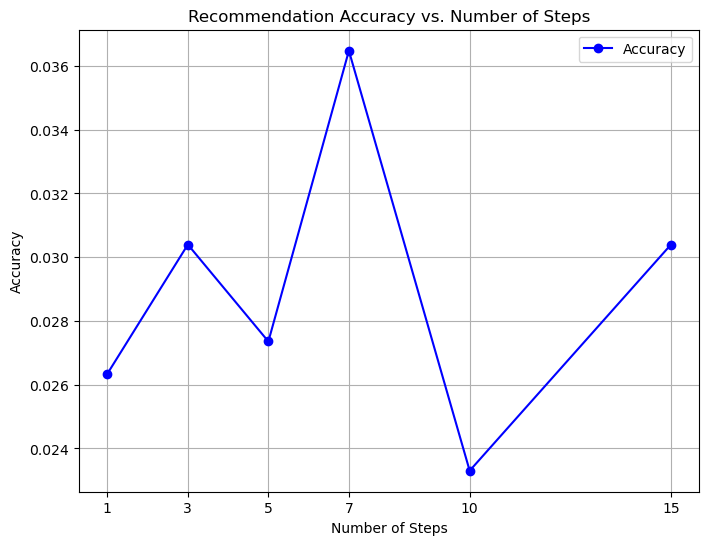

In [5]:
import igraph as ig
import random
import json
from tqdm.notebook import tqdm
import numpy as np
import logging
logger = logging.getLogger(__name__)


# setup logging to print all info
logging.basicConfig(level=logging.INFO)

# Step 1: Load the graph from GraphML
# graph = ig.Graph.Read_GraphML(track_network_path)
# graph.to_undirected()  # Ensure the graph is undirected

random.seed(42)

# Step 2: Random walk function avoiding tracks in user's playlist
def weighted_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps):
    walk = [start_node]
    current_node = start_node

    for _ in range(num_steps):
        neighbors = graph.neighbors(current_node, mode="all")

        # Exclude neighbors associated with the user's playlist ID
        valid_neighbors = [
            neighbor for neighbor in neighbors
            #if user_pid not in map(int, graph.vs[neighbor]["playlists"].split(","))
        ]
        if not valid_neighbors:
            break  # Stop if no valid neighbors

        edge_ids = [graph.get_eid(current_node, neighbor) for neighbor in valid_neighbors]
        weights = [graph.es[edge_id]["weight"] for edge_id in edge_ids]

        next_node = random.choices(valid_neighbors, weights=weights, k=1)[0]
        walk.append(next_node)
        current_node = next_node

    return walk

# Step 3: Recommendation function
def recommend_tracks_by_pid(graph, user_pid, user_track, num_steps=5, top_n=1):
    try:
        start_node = graph.vs.find(id=user_track).index
    except ValueError:
        # raise ValueError(f"Track '{user_track}' not found in the graph.")
        # print('nope')
        return None

    walk = weighted_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps)

    visit_counts = {}
    for node in walk:
        track_id = graph.vs[node]["id"]
        #if user_pid not in map(int, graph.vs[node]["playlists"].split(",")):
        visit_counts[track_id] = visit_counts.get(track_id, 0) + 1

    recommended_tracks = sorted(visit_counts, key=visit_counts.get, reverse=True)
    eligible_tracks = [track for track in recommended_tracks if track != user_track]
    return eligible_tracks[:top_n]

# Step 4: Accuracy testing function
def test_recommendation_accuracy(graph, test_data_path, num_steps=5, top_n=1):
    with open(test_data_path, "r") as f:
        test_data = json.load(f)

    playlists = test_data["playlists"]
    total_tests = 0
    successful_tests = 0

    input_track_uris_per_playlist = {}
    eligible_input_uri_per_playlist = {}
    for playlist in tqdm(playlists, desc="Processing playlists"):
        this_track_uris = [track["track_uri"] for track in playlist["tracks"]]
        input_track_uris_per_playlist[playlist["pid"]] = this_track_uris
        tracks_in_graph = [track_uri for track_uri in this_track_uris if track_uri in graph.vs["id"]]
        eligible_input_uri_per_playlist[playlist["pid"]] = random.choice(tracks_in_graph) if len(tracks_in_graph) > 0 else None

    # filter key
    testable_playlists = [pid for pid in input_track_uris_per_playlist.keys() if eligible_input_uri_per_playlist[pid] != None]
    recommendation_success = np.zeros(len(testable_playlists))
    recommended_degree = np.zeros(len(testable_playlists))

    for i, pid in enumerate(tqdm(testable_playlists, desc="Testing playlists")):
        input_track_uris = input_track_uris_per_playlist[pid]
        eligible_input_uri = eligible_input_uri_per_playlist[pid]
        recommended_tracks = recommend_tracks_by_pid(graph, pid, eligible_input_uri, num_steps, top_n)
        if recommended_tracks is not None:
            recommended_degrees = [graph.degree(graph.vs.find(id=track).index) for track in recommended_tracks]
            recommended_degree[i] = np.mean(recommended_degrees)
            if any(track in recommended_tracks for track in input_track_uris):
                recommendation_success[i] = 1
        else:
            recommended_degree[i] = 0


    accuracy = np.mean(recommendation_success)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    mean_recommended_degree = np.mean(recommended_degree)
    print(f"Mean recommended degree: {mean_recommended_degree:.2f}")

    recommendation_scores = recommendation_success / np.log10(recommended_degree)
    mean_recommendation_score = np.mean(recommendation_scores)
    print(f"Mean recommendation score: {mean_recommendation_score:.2f}")



    # Add tqdm progress bar for playlists
    # for playlist in tqdm(playlists, desc="Testing playlists"):
    #     user_pid = playlist["pid"]
    #     input_track_index = 0
    #     input_track = playlist["tracks"][input_track_index]["track_uri"]
    #     ground_truth_tracks = {track["track_uri"] for track in playlist["tracks"]}
        
    #     try:
    #         while input_track_index < len(playlist["tracks"]):
    #             input_track = playlist["tracks"][input_track_index]["track_uri"]
    #             recommended_tracks = recommend_tracks_by_pid(
    #                 graph, user_pid, input_track, num_steps, top_n
    #             )
    #             logger.info(f"Recommended tracks: {recommended_tracks} for input track: {input_track}")
    #             if recommended_tracks is None:
    #                 input_track_index += 1
    #                 continue
    #             else:
    #                 total_tests += 1
    #                 if any(track in ground_truth_tracks for track in recommended_tracks):
    #                     successful_tests += 1
    #                 break
    #     except ValueError as e:
    #         print(e)

    # accuracy = successful_tests / total_tests if total_tests > 0 else 0
    # print(f"\nAccuracy: {accuracy * 100:.2f}% ({successful_tests}/{total_tests})")
    return accuracy

# Step 5: Run the test
test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"  # Path to your test JSON file
# test_recommendation_accuracy(graph, test_data_path, num_steps=10, top_n=1)

# steps = [1, 3, 5, 7, 10, 15]
# for step in steps:
#     test_recommendation_accuracy(graph, test_data_path, num_steps=step, top_n=1)
import matplotlib.pyplot as plt

# Define the steps and initialize a list to store accuracies
steps = [1, 3, 5, 7, 10, 15]
accuracies = []

# Run the accuracy test for each step and store the results
for step in steps:
    print(f"Testing num_steps={step}")
    accuracy = test_recommendation_accuracy(graph, test_data_path, num_steps=step, top_n=1)
    accuracies.append(accuracy)

# Plot the line chart
plt.figure(figsize=(8, 6))
plt.plot(steps, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.title("Recommendation Accuracy vs. Number of Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Accuracy")
plt.xticks(steps)  # Ensure steps are marked on the x-axis
plt.grid(True)
plt.legend()
plt.show()


## Plain Random Walk Distance Metric

Testing num_steps=1


Processing playlists:   0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/nq/b7pjjp05003dqcdxtbz9ws6w0000gn/T/ipykernel_59483/1094005663.py:98: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  graph.shortest_paths(recommended_node, other_node)[0][0]
INFO:__main__:Mean Distance: 1.17
INFO:__main__:Median Distance: 1.00


Testing num_steps=3


Processing playlists:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:__main__:Mean Distance: 1.17
INFO:__main__:Median Distance: 1.00


Testing num_steps=5


Processing playlists:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:__main__:Mean Distance: 1.33
INFO:__main__:Median Distance: 1.00


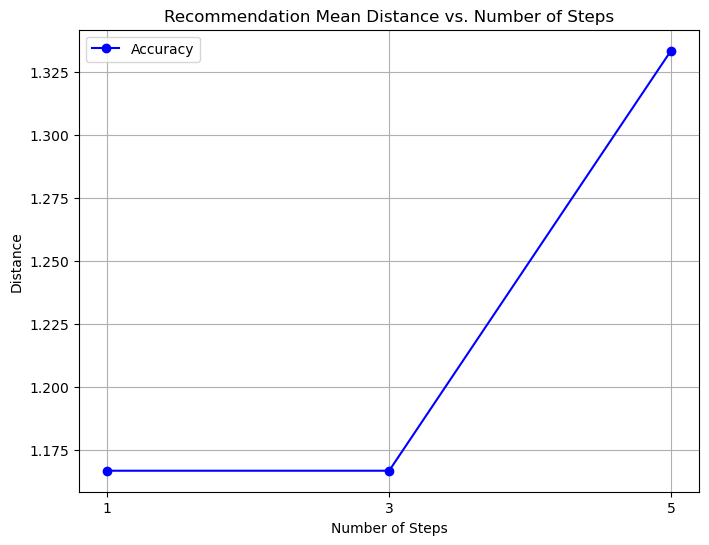

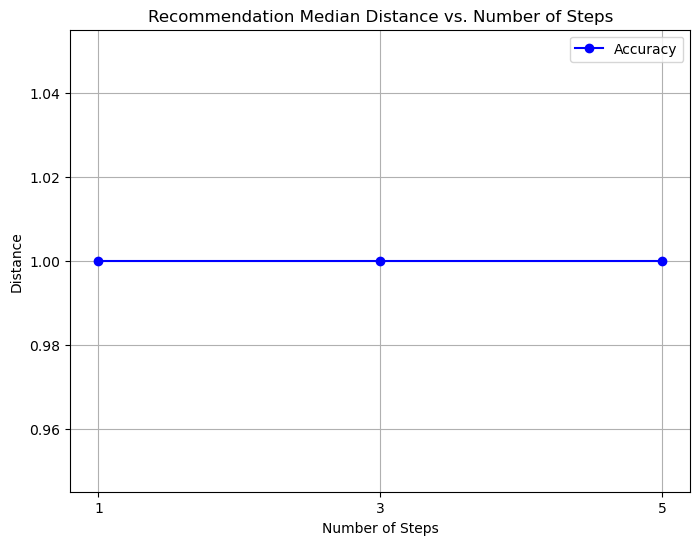

In [25]:
import igraph as ig
import random
import json
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
import numpy as np

# Setup logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

random.seed(42)

# Step 2: Random walk function avoiding tracks in user's playlist
def weighted_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps):
    walk = [start_node]
    current_node = start_node

    for _ in range(num_steps):
        neighbors = graph.neighbors(current_node, mode="all")

        # Exclude neighbors associated with the user's playlist ID
        valid_neighbors = [
            neighbor for neighbor in neighbors
        ]
        if not valid_neighbors:
            break  # Stop if no valid neighbors

        edge_ids = [graph.get_eid(current_node, neighbor) for neighbor in valid_neighbors]
        weights = [graph.es[edge_id]["weight"] for edge_id in edge_ids]

        next_node = random.choices(valid_neighbors, weights=weights, k=1)[0]
        walk.append(next_node)
        current_node = next_node

    return walk

# Step 3: Recommendation function with distance-based scoring
def recommend_tracks_by_pid(graph, user_pid, user_track, num_steps=5, top_n=1):
    try:
        start_node = graph.vs.find(id=user_track).index
    except ValueError:
        # raise ValueError(f"Track '{user_track}' not found in the graph.")
        # print('nope')
        return None

    walk = weighted_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps)

    visit_counts = {}
    for node in walk:
        track_id = graph.vs[node]["id"]
        #if user_pid not in map(int, graph.vs[node]["playlists"].split(",")):
        visit_counts[track_id] = visit_counts.get(track_id, 0) + 1

    recommended_tracks = sorted(visit_counts, key=visit_counts.get, reverse=True)
    eligible_tracks = [track for track in recommended_tracks if track != user_track]
    return eligible_tracks[:top_n]

# Step 4: Calculate and visualize distance metrics
def calculate_and_visualize_distance_metrics(graph, test_data_path, num_steps=5, top_n=1):
    with open(test_data_path, "r") as f:
        test_data = json.load(f)

    playlists = test_data["playlists"]
    distances = []

    for playlist in tqdm(playlists, desc="Processing playlists"):
        user_pid = playlist["pid"]
        input_track = playlist["tracks"][0]["track_uri"]  # First track in the playlist

        try:
            recommended_tracks = recommend_tracks_by_pid(
                graph, user_pid, input_track, num_steps, top_n
            )

            if recommended_tracks:
                for recommended_track in recommended_tracks:
                    try:
                        recommended_node = graph.vs.find(id=recommended_track).index

                        # Calculate distances to all tracks in the playlist
                        # Calculate distance to playlist tracks only
                        def safe_find_vertex(graph, track_uri):
                            try:
                                return graph.vs.find(id=track_uri).index
                            except ValueError:
                                return None
                    
                        playlist_nodes = [
                            safe_find_vertex(graph, track["track_uri"])
                            for track in playlist["tracks"]
                            if track["track_uri"] != input_track
                        ]
                        playlist_nodes = [node for node in playlist_nodes if node is not None]  # Remove None entries

                        distances_to_playlist = [
                            graph.shortest_paths(recommended_node, other_node)[0][0]
                            for other_node in playlist_nodes
                        ]

                        if distances_to_playlist:
                            distances.append(min(distances_to_playlist))
                    except ValueError:
                        logger.error(f"Recommended track '{recommended_track}' not found in the graph.")

        except ValueError as e:
            logger.error(e)

    if distances:
        mean_distance = np.mean(distances)
        median_distance = np.median(distances)

        logger.info(f"Mean Distance: {mean_distance:.2f}")
        logger.info(f"Median Distance: {median_distance:.2f}")

        return mean_distance, median_distance
    else:
        logger.info("No distances to visualize.")
        return None, None

test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"


import matplotlib.pyplot as plt

steps = [1, 3, 5, 7, 10, 15]
mean_distances_result = []
median_distances_result = []

for step in steps:
    print(f"Testing num_steps={step}")
    mean_distance, median_distance = calculate_and_visualize_distance_metrics(graph, test_data_path, num_steps=step, top_n=1)
    mean_distances_result.append(mean_distance)
    median_distances_result.append(median_distance)

# Plot the line chart
plt.figure(figsize=(8, 6))
plt.plot(steps, mean_distances_result, marker='o', linestyle='-', color='b', label="Accuracy")
plt.title("Recommendation Mean Distance vs. Number of Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Distance")
plt.xticks(steps)  # Ensure steps are marked on the x-axis
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(steps, median_distances_result, marker='o', linestyle='-', color='b', label="Accuracy")
plt.title("Recommendation Median Distance vs. Number of Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Distance")
plt.xticks(steps)  # Ensure steps are marked on the x-axis
plt.grid(True)
plt.legend()
plt.show()


# Node2Vec Random Walk

In [17]:
import igraph as ig
import random
import json

# Step 1: Load the graph from GraphML
# graph = ig.Graph.Read_GraphML("../network-parser/track_graph.graphml")
# graph.to_undirected()  # Ensure the graph is undirected

# random.seed(43)

# Step 2: Define the Node2Vec random walk function
def node2vec_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, p=1.0, q=1.0):
    """
    Perform a Node2Vec-style random walk while avoiding tracks in the user's playlist ID.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        start_node (int): The starting node index for the random walk.
        user_pid (int): The user's playlist ID to exclude tracks from.
        num_steps (int): Number of steps for the random walk.
        p (float): Return parameter (controls likelihood of returning to the previous node).
        q (float): In-out parameter (controls exploration of closer vs. farther nodes).
        
    Returns:
        list: A list of visited node indices during the random walk.
    """
    walk = [start_node]
    current_node = start_node
    previous_node = None

    for _ in range(num_steps):
        neighbors = graph.neighbors(current_node, mode="all")

        # Exclude neighbors associated with the user's playlist ID
        valid_neighbors = [
            neighbor for neighbor in neighbors
            #if user_pid not in map(int, graph.vs[neighbor]["playlists"].split(","))
        ]
        if not valid_neighbors:
            break  # Stop if no valid neighbors

        edge_ids = [graph.get_eid(current_node, neighbor) for neighbor in valid_neighbors]
        weights = []

        for neighbor, edge_id in zip(valid_neighbors, edge_ids):
            if previous_node is not None and neighbor == previous_node:
                # Bias for returning to the previous node
                weights.append(graph.es[edge_id]["weight"] / p)
            elif previous_node is not None:
                # Bias for exploring farther or closer nodes
                distance_factor = 1.0 if neighbor in graph.neighbors(previous_node) else q
                weights.append(graph.es[edge_id]["weight"] / distance_factor)
            else:
                # First step, no previous node
                weights.append(graph.es[edge_id]["weight"])

        next_node = random.choices(valid_neighbors, weights=weights, k=1)[0]
        walk.append(next_node)
        previous_node = current_node
        current_node = next_node

    return walk

# Step 3: Recommendation function
def recommend_tracks_by_pid_node2vec(graph, user_pid, user_track, num_steps=5, top_n=1, p=1.0, q=1.0):
    """
    Recommend tracks based on a Node2Vec random walk avoiding tracks in the user's playlist.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        user_pid (int): The user's playlist ID to exclude tracks from.
        user_track (str): The track ID of the starting node.
        num_steps (int): Number of steps for the random walk.
        top_n (int): Number of recommendations to return.
        p (float): Return parameter (controls likelihood of returning to the previous node).
        q (float): In-out parameter (controls exploration of closer vs. farther nodes).
        
    Returns:
        list: A list of recommended track IDs.
    """
    try:
        start_node = graph.vs.find(id=user_track).index
    except ValueError:
        #raise ValueError(f"Track '{user_track}' not found in the graph.")
        return None

    walk = node2vec_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, p, q)

    visit_counts = {}
    for node in walk:
        track_id = graph.vs[node]["id"]
        #if user_pid not in map(int, graph.vs[node]["playlists"].split(",")):
        visit_counts[track_id] = visit_counts.get(track_id, 0) + 1

    recommended_tracks = sorted(visit_counts, key=visit_counts.get, reverse=True)
    eligible_tracks = [track for track in recommended_tracks if track != user_track]
    return eligible_tracks[:top_n]

# Step 4: Accuracy testing function
def test_recommendation_accuracy_node2vec(graph, test_data_path, num_steps=5, top_n=1, p=1.0, q=1.0):
    with open(test_data_path, "r") as f:
        test_data = json.load(f)

    playlists = test_data["playlists"]
    total_tests = 0
    successful_tests = 0

    # Add tqdm progress bar for playlists
    # for playlist in tqdm(playlists, desc="Testing playlists"):
    for playlist in playlists:
        user_pid = playlist["pid"]
        input_track_index = 0
        input_track = playlist["tracks"][input_track_index]["track_uri"]
        ground_truth_tracks = {track["track_uri"] for track in playlist["tracks"]}
        
        try:
            while input_track_index < len(playlist["tracks"]):
                input_track = playlist["tracks"][input_track_index]["track_uri"]
                recommended_tracks = recommend_tracks_by_pid_node2vec(
                    graph, user_pid, input_track, num_steps, top_n, p, q
                )
                # logger.info(f"Recommended tracks: {recommended_tracks} for input track: {input_track}")
                if recommended_tracks is None:
                    input_track_index += 1
                    continue
                else:
                    total_tests += 1
                    if any(track in ground_truth_tracks for track in recommended_tracks):
                        successful_tests += 1
                    break
        except ValueError as e:
            print(e)

    accuracy = successful_tests / total_tests
    print(f"Accuracy: {accuracy * 100:.2f}% ({successful_tests}/{total_tests})")
    return accuracy


# Step 5: Run the test
test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"  # Path to your test JSON file
# test_recommendation_accuracy_node2vec(graph, test_data_path, p=0.25, q=0.25, num_steps=7, top_n=1)


In [18]:
import itertools
import random
from tqdm import tqdm

# Define parameter ranges
p_values = [0.25, 0.5, 1.0, 2.0, 4.0]
q_values = [0.25, 0.5, 1.0, 2.0, 4.0]
num_steps_values = 7
top_n_values = 1

# Use grid search or random sampling
grid_search = True  # Set to False for random sampling
num_random_samples = 10  # Only relevant for random search

# Prepare combinations of parameters
if grid_search:
    param_combinations = list(itertools.product(p_values, q_values))
else:
    param_combinations = [
        (
            random.choice(p_values),
            random.choice(q_values),
        )
        for _ in range(num_random_samples)
    ]

# Best parameter tracking
best_accuracy = 0
best_params = None

results = []
# Loop through parameter combinations
for p, q in tqdm(param_combinations, desc="Parameter tuning"):
    print(f"Testing parameters: p={p}, q={q}, num_steps={num_steps}, top_n={top_n}")
    try:
        accuracy = test_recommendation_accuracy_node2vec(
            graph, test_data_path, num_steps=num_steps_values, top_n=top_n_values, p=p, q=q
        )
        print(f"Accuracy: {accuracy:.4f}")

        # Update best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (p, q, num_steps, top_n)
        results.append((p, q, accuracy))
    except Exception as e:
        print(f"Error with parameters p={p}, q={q}, num_steps={num_steps}, top_n={top_n}: {e}")

# Print the best parameters
print(f"\nBest Parameters: p={best_params[0]}, q={best_params[1]}, num_steps={best_params[2]}, top_n={best_params[3]}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Parameter tuning:   0%|                                  | 0/25 [00:00<?, ?it/s]

Testing parameters: p=0.25, q=0.25, num_steps=7, top_n=1


Parameter tuning:   4%|█                        | 1/25 [02:19<55:42, 139.26s/it]

Accuracy: 1.72% (17/987)
Accuracy: 0.0172
Testing parameters: p=0.25, q=0.5, num_steps=7, top_n=1


Parameter tuning:   8%|██                       | 2/25 [04:44<54:39, 142.58s/it]

Accuracy: 3.44% (34/987)
Accuracy: 0.0344
Testing parameters: p=0.25, q=1.0, num_steps=7, top_n=1


Parameter tuning:  12%|███                      | 3/25 [07:03<51:46, 141.19s/it]

Accuracy: 3.55% (35/987)
Accuracy: 0.0355
Testing parameters: p=0.25, q=2.0, num_steps=7, top_n=1


Parameter tuning:  16%|████                     | 4/25 [09:33<50:39, 144.75s/it]

Accuracy: 3.34% (33/987)
Accuracy: 0.0334
Testing parameters: p=0.25, q=4.0, num_steps=7, top_n=1


Parameter tuning:  20%|█████                    | 5/25 [12:08<49:27, 148.38s/it]

Accuracy: 2.84% (28/987)
Accuracy: 0.0284
Testing parameters: p=0.5, q=0.25, num_steps=7, top_n=1


Parameter tuning:  24%|██████                   | 6/25 [14:33<46:34, 147.10s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: p=0.5, q=0.5, num_steps=7, top_n=1


Parameter tuning:  28%|███████                  | 7/25 [16:55<43:37, 145.44s/it]

Accuracy: 2.63% (26/987)
Accuracy: 0.0263
Testing parameters: p=0.5, q=1.0, num_steps=7, top_n=1


Parameter tuning:  32%|████████                 | 8/25 [19:27<41:47, 147.50s/it]

Accuracy: 3.14% (31/987)
Accuracy: 0.0314
Testing parameters: p=0.5, q=2.0, num_steps=7, top_n=1


Parameter tuning:  36%|█████████                | 9/25 [21:48<38:49, 145.61s/it]

Accuracy: 2.33% (23/987)
Accuracy: 0.0233
Testing parameters: p=0.5, q=4.0, num_steps=7, top_n=1


Parameter tuning:  40%|█████████▌              | 10/25 [24:09<36:03, 144.22s/it]

Accuracy: 2.43% (24/987)
Accuracy: 0.0243
Testing parameters: p=1.0, q=0.25, num_steps=7, top_n=1


Parameter tuning:  44%|██████████▌             | 11/25 [26:31<33:29, 143.51s/it]

Accuracy: 3.24% (32/987)
Accuracy: 0.0324
Testing parameters: p=1.0, q=0.5, num_steps=7, top_n=1


Parameter tuning:  48%|███████████▌            | 12/25 [28:52<30:55, 142.73s/it]

Accuracy: 2.74% (27/987)
Accuracy: 0.0274
Testing parameters: p=1.0, q=1.0, num_steps=7, top_n=1


Parameter tuning:  52%|████████████▍           | 13/25 [31:14<28:29, 142.46s/it]

Accuracy: 2.23% (22/987)
Accuracy: 0.0223
Testing parameters: p=1.0, q=2.0, num_steps=7, top_n=1


Parameter tuning:  56%|█████████████▍          | 14/25 [33:41<26:21, 143.78s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: p=1.0, q=4.0, num_steps=7, top_n=1


Parameter tuning:  60%|██████████████▍         | 15/25 [36:00<23:43, 142.40s/it]

Accuracy: 3.14% (31/987)
Accuracy: 0.0314
Testing parameters: p=2.0, q=0.25, num_steps=7, top_n=1


Parameter tuning:  64%|███████████████▎        | 16/25 [38:20<21:14, 141.63s/it]

Accuracy: 2.03% (20/987)
Accuracy: 0.0203
Testing parameters: p=2.0, q=0.5, num_steps=7, top_n=1


Parameter tuning:  68%|████████████████▎       | 17/25 [40:43<18:55, 141.96s/it]

Accuracy: 2.74% (27/987)
Accuracy: 0.0274
Testing parameters: p=2.0, q=1.0, num_steps=7, top_n=1


Parameter tuning:  72%|█████████████████▎      | 18/25 [43:12<16:48, 144.08s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: p=2.0, q=2.0, num_steps=7, top_n=1


Parameter tuning:  76%|██████████████████▏     | 19/25 [45:39<14:30, 145.00s/it]

Accuracy: 3.85% (38/987)
Accuracy: 0.0385
Testing parameters: p=2.0, q=4.0, num_steps=7, top_n=1


Parameter tuning:  80%|███████████████████▏    | 20/25 [48:10<12:14, 146.94s/it]

Accuracy: 2.74% (27/987)
Accuracy: 0.0274
Testing parameters: p=4.0, q=0.25, num_steps=7, top_n=1


Parameter tuning:  84%|████████████████████▏   | 21/25 [50:31<09:40, 145.09s/it]

Accuracy: 2.53% (25/987)
Accuracy: 0.0253
Testing parameters: p=4.0, q=0.5, num_steps=7, top_n=1


Parameter tuning:  88%|█████████████████████   | 22/25 [52:45<07:05, 141.83s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: p=4.0, q=1.0, num_steps=7, top_n=1


Parameter tuning:  92%|██████████████████████  | 23/25 [55:12<04:46, 143.32s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: p=4.0, q=2.0, num_steps=7, top_n=1


Parameter tuning:  96%|███████████████████████ | 24/25 [57:33<02:22, 142.71s/it]

Accuracy: 2.13% (21/987)
Accuracy: 0.0213
Testing parameters: p=4.0, q=4.0, num_steps=7, top_n=1


Parameter tuning: 100%|██████████████████████| 25/25 [1:00:02<00:00, 144.12s/it]

Accuracy: 3.14% (31/987)
Accuracy: 0.0314

Best Parameters: p=2.0, q=2.0, num_steps=7, top_n=1
Best Accuracy: 0.0385


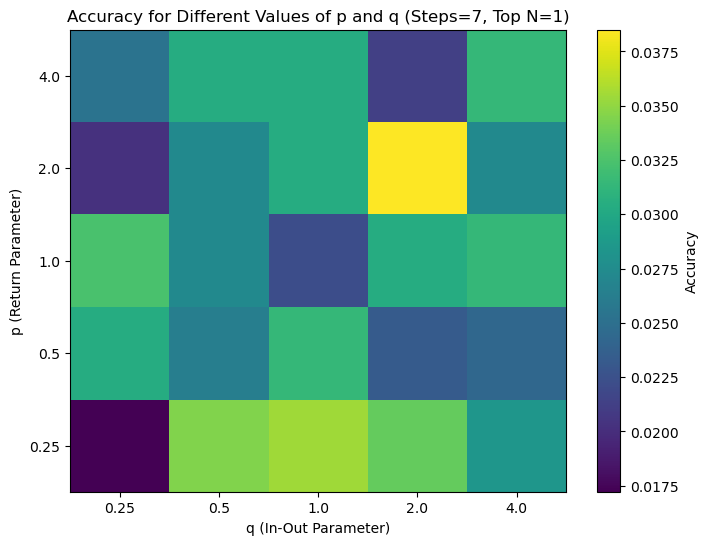

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
p_values = sorted(set([res[0] for res in results]))
q_values = sorted(set([res[1] for res in results]))

# Create an accuracy grid
accuracy_grid = np.zeros((len(p_values), len(q_values)))

# Populate the grid with accuracy values
for p, q, accuracy in results:
    p_index = p_values.index(p)
    q_index = q_values.index(q)
    accuracy_grid[p_index, q_index] = accuracy

# Plot using imshow for uniform cells
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_grid, cmap="viridis", origin="lower", aspect="auto")

# Set custom tick labels for x and y axes
plt.xticks(ticks=np.arange(len(q_values)), labels=q_values)
plt.yticks(ticks=np.arange(len(p_values)), labels=p_values)

# Add colorbar and labels
plt.colorbar(label="Accuracy")
plt.xlabel("q (In-Out Parameter)")
plt.ylabel("p (Return Parameter)")
plt.title(f"Accuracy for Different Values of p and q (Steps=7, Top N={top_n})")
plt.show()


## Node2Vec Random Walk Distance Metric

In [30]:
import igraph as ig
import random
import json

# Step 1: Load the graph from GraphML
# graph = ig.Graph.Read_GraphML("../network-parser/track_graph.graphml")
# graph.to_undirected()  # Ensure the graph is undirected

# random.seed(43)

# Step 2: Define the Node2Vec random walk function
def node2vec_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, p=1.0, q=1.0):
    """
    Perform a Node2Vec-style random walk while avoiding tracks in the user's playlist ID.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        start_node (int): The starting node index for the random walk.
        user_pid (int): The user's playlist ID to exclude tracks from.
        num_steps (int): Number of steps for the random walk.
        p (float): Return parameter (controls likelihood of returning to the previous node).
        q (float): In-out parameter (controls exploration of closer vs. farther nodes).
        
    Returns:
        list: A list of visited node indices during the random walk.
    """
    walk = [start_node]
    current_node = start_node
    previous_node = None

    for _ in range(num_steps):
        neighbors = graph.neighbors(current_node, mode="all")

        # Exclude neighbors associated with the user's playlist ID
        valid_neighbors = [
            neighbor for neighbor in neighbors
            #if user_pid not in map(int, graph.vs[neighbor]["playlists"].split(","))
        ]
        if not valid_neighbors:
            break  # Stop if no valid neighbors

        edge_ids = [graph.get_eid(current_node, neighbor) for neighbor in valid_neighbors]
        weights = []

        for neighbor, edge_id in zip(valid_neighbors, edge_ids):
            if previous_node is not None and neighbor == previous_node:
                # Bias for returning to the previous node
                weights.append(graph.es[edge_id]["weight"] / p)
            elif previous_node is not None:
                # Bias for exploring farther or closer nodes
                distance_factor = 1.0 if neighbor in graph.neighbors(previous_node) else q
                weights.append(graph.es[edge_id]["weight"] / distance_factor)
            else:
                # First step, no previous node
                weights.append(graph.es[edge_id]["weight"])

        next_node = random.choices(valid_neighbors, weights=weights, k=1)[0]
        walk.append(next_node)
        previous_node = current_node
        current_node = next_node

    return walk

# Step 3: Recommendation function
def recommend_tracks_by_pid_node2vec(graph, user_pid, user_track, num_steps=5, top_n=1, p=1.0, q=1.0):
    """
    Recommend tracks based on a Node2Vec random walk avoiding tracks in the user's playlist.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        user_pid (int): The user's playlist ID to exclude tracks from.
        user_track (str): The track ID of the starting node.
        num_steps (int): Number of steps for the random walk.
        top_n (int): Number of recommendations to return.
        p (float): Return parameter (controls likelihood of returning to the previous node).
        q (float): In-out parameter (controls exploration of closer vs. farther nodes).
        
    Returns:
        list: A list of recommended track IDs.
    """
    try:
        start_node = graph.vs.find(id=user_track).index
    except ValueError:
        #raise ValueError(f"Track '{user_track}' not found in the graph.")
        return None

    walk = node2vec_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, p, q)

    visit_counts = {}
    for node in walk:
        track_id = graph.vs[node]["id"]
        #if user_pid not in map(int, graph.vs[node]["playlists"].split(",")):
        visit_counts[track_id] = visit_counts.get(track_id, 0) + 1

    recommended_tracks = sorted(visit_counts, key=visit_counts.get, reverse=True)
    eligible_tracks = [track for track in recommended_tracks if track != user_track]
    return eligible_tracks[:top_n]

# Step 4: Accuracy testing function
def calculate_and_visualize_distance_metrics_node2vec(graph, test_data_path, num_steps=5, top_n=1, p=1.0, q=1.0):
    with open(test_data_path, "r") as f:
        test_data = json.load(f)

    playlists = test_data["playlists"]
    distances = []

    for playlist in playlists:
        user_pid = playlist["pid"]
        input_track = playlist["tracks"][0]["track_uri"]  # First track in the playlist

        try:
            recommended_tracks = recommend_tracks_by_pid_node2vec(
                graph, user_pid, input_track, num_steps, top_n, p, q
            )

            if recommended_tracks:
                for recommended_track in recommended_tracks:
                    try:
                        recommended_node = graph.vs.find(id=recommended_track).index

                        # Calculate distances to all tracks in the playlist
                        # Calculate distance to playlist tracks only
                        def safe_find_vertex(graph, track_uri):
                            try:
                                return graph.vs.find(id=track_uri).index
                            except ValueError:
                                return None
                    
                        playlist_nodes = [
                            safe_find_vertex(graph, track["track_uri"])
                            for track in playlist["tracks"]
                            if track["track_uri"] != input_track
                        ]
                        playlist_nodes = [node for node in playlist_nodes if node is not None]  # Remove None entries

                        distances_to_playlist = [
                            graph.shortest_paths(recommended_node, other_node)[0][0]
                            for other_node in playlist_nodes
                        ]

                        if distances_to_playlist:
                            distances.append(min(distances_to_playlist))
                    except ValueError:
                        logger.error(f"Recommended track '{recommended_track}' not found in the graph.")

        except ValueError as e:
            logger.error(e)

    if distances:
        mean_distance = np.mean(distances)
        median_distance = np.median(distances)

        logger.info(f"Mean Distance: {mean_distance:.2f}")
        logger.info(f"Median Distance: {median_distance:.2f}")

        return mean_distance, median_distance
    else:
        logger.info("No distances to visualize.")
        return None, None


# Step 5: Run the test
test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"  # Path to your test JSON file
# test_recommendation_accuracy_node2vec(graph, test_data_path, p=0.25, q=0.25, num_steps=7, top_n=1)


In [33]:
import itertools
import random
from tqdm import tqdm

# Define parameter ranges
p_values = [0.25, 0.5, 1.0, 2.0, 4.0]
q_values = [0.25, 0.5, 1.0, 2.0, 4.0]
num_steps_values = 5
top_n_values = 1

# Use grid search or random sampling
grid_search = True  # Set to False for random sampling
num_random_samples = 10  # Only relevant for random search

# Prepare combinations of parameters
if grid_search:
    param_combinations = list(itertools.product(p_values, q_values))
else:
    param_combinations = [
        (
            random.choice(p_values),
            random.choice(q_values),
        )
        for _ in range(num_random_samples)
    ]

# Best parameter tracking
best_distance = 0
best_params = None

results = []
# Loop through parameter combinations
for p, q in tqdm(param_combinations, desc="Parameter tuning"):
    print(f"Testing parameters: p={p}, q={q}, num_steps={num_steps_values}, top_n={top_n_values}")
    try:
        mean_distance, median_distance = calculate_and_visualize_distance_metrics_node2vec(
            graph, test_data_path, num_steps=num_steps_values, top_n=top_n_values, p=p, q=q
        )
        print(f"Mean Distance: {mean_distance:.4f}")

        # Update best parameters
        if mean_distance > best_distance:
            best_distance = mean_distance
            best_params = (p, q, num_steps_values, top_n_values)
        results.append((p, q, mean_distance))
    except Exception as e:
        print(f"Error with parameters p={p}, q={q}, num_steps={num_steps_values}, top_n={top_n}: {e}")

# Print the best parameters
print(f"\nBest Parameters: p={best_params[0]}, q={best_params[1]}, num_steps={best_params[2]}, top_n={best_params[3]}")
print(f"Best Mean Distance: {best_distance:.4f}")


Parameter tuning:   0%|                                           | 0/4 [00:00<?, ?it/s]

Testing parameters: p=0.25, q=0.25, num_steps=3, top_n=1


/var/folders/nq/b7pjjp05003dqcdxtbz9ws6w0000gn/T/ipykernel_59483/130405152.py:137: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  graph.shortest_paths(recommended_node, other_node)[0][0]
INFO:__main__:Mean Distance: 1.33
INFO:__main__:Median Distance: 1.00
Parameter tuning:  25%|████████▊                          | 1/4 [01:15<03:46, 75.37s/it]

Mean Distance: 1.3333
Testing parameters: p=0.25, q=0.5, num_steps=3, top_n=1


INFO:__main__:Mean Distance: 1.17
INFO:__main__:Median Distance: 1.00
Parameter tuning:  50%|█████████████████▌                 | 2/4 [02:30<02:30, 75.21s/it]

Mean Distance: 1.1667
Testing parameters: p=0.5, q=0.25, num_steps=3, top_n=1


INFO:__main__:Mean Distance: 1.50
INFO:__main__:Median Distance: 1.50
Parameter tuning:  75%|██████████████████████████▎        | 3/4 [03:46<01:15, 75.60s/it]

Mean Distance: 1.5000
Testing parameters: p=0.5, q=0.5, num_steps=3, top_n=1


INFO:__main__:Mean Distance: 1.17
INFO:__main__:Median Distance: 1.00
Parameter tuning: 100%|███████████████████████████████████| 4/4 [05:01<00:00, 75.35s/it]

Mean Distance: 1.1667

Best Parameters: p=0.5, q=0.25, num_steps=3, top_n=1
Best Mean Distance: 1.5000


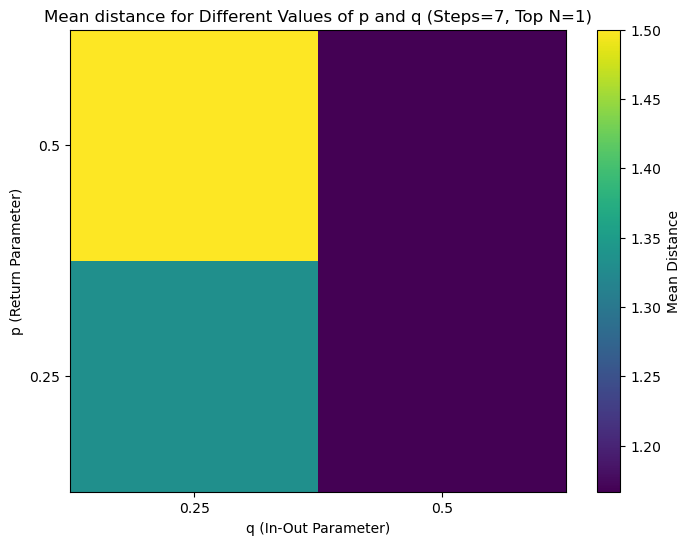

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
p_values = sorted(set([res[0] for res in results]))
q_values = sorted(set([res[1] for res in results]))

# Create an accuracy grid
accuracy_grid = np.zeros((len(p_values), len(q_values)))

# Populate the grid with accuracy values
for p, q, accuracy in results:
    p_index = p_values.index(p)
    q_index = q_values.index(q)
    accuracy_grid[p_index, q_index] = accuracy

# Plot using imshow for uniform cells
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_grid, cmap="viridis", origin="lower", aspect="auto")

# Set custom tick labels for x and y axes
plt.xticks(ticks=np.arange(len(q_values)), labels=q_values)
plt.yticks(ticks=np.arange(len(p_values)), labels=p_values)

# Add colorbar and labels
plt.colorbar(label="Mean Distance")
plt.xlabel("q (In-Out Parameter)")
plt.ylabel("p (Return Parameter)")
plt.title(f"Mean distance for Different Values of p and q (Steps=7, Top N=1)")
plt.show()


# Restart Random Walk

In [22]:
import igraph as ig
import random
import json

# Step 1: Load the graph from GraphML
# graph = ig.Graph.Read_GraphML("../network-parser/track_graph.graphml")
# graph.to_undirected()  # Ensure the graph is undirected

# random.seed(44)

# Step 2: Define the Restart Random Walk function
def restart_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, restart_prob=0.15):
    """
    Perform a restart random walk while avoiding tracks in the user's playlist ID.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        start_node (int): The starting node index for the random walk.
        user_pid (int): The user's playlist ID to exclude tracks from.
        num_steps (int): Number of steps for the random walk.
        restart_prob (float): Probability of restarting the walk at the starting node.
        
    Returns:
        list: A list of visited node indices during the random walk.
    """
    walk = [start_node]
    current_node = start_node

    for _ in range(num_steps):
        if random.random() < restart_prob:
            # Restart to the starting node
            current_node = start_node
        else:
            neighbors = graph.neighbors(current_node, mode="all")

            # Exclude neighbors associated with the user's playlist ID
            valid_neighbors = [
                neighbor for neighbor in neighbors
                #if user_pid not in map(int, graph.vs[neighbor]["playlists"].split(","))
            ]
            if not valid_neighbors:
                break  # Stop if no valid neighbors

            # Get edge weights for valid neighbors
            edge_ids = [graph.get_eid(current_node, neighbor) for neighbor in valid_neighbors]
            weights = [graph.es[edge_id]["weight"] for edge_id in edge_ids]

            current_node = random.choices(valid_neighbors, weights=weights, k=1)[0]

        walk.append(current_node)

    return walk

# Step 3: Recommendation function
def recommend_tracks_by_pid_restart(graph, user_pid, user_track, num_steps=5, top_n=1, restart_prob=0.15):
    """
    Recommend tracks based on a restart random walk avoiding tracks in the user's playlist.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        user_pid (int): The user's playlist ID to exclude tracks from.
        user_track (str): The track ID of the starting node.
        num_steps (int): Number of steps for the random walk.
        top_n (int): Number of recommendations to return.
        restart_prob (float): Probability of restarting the walk at the starting node.
        
    Returns:
        list: A list of recommended track IDs.
    """
    try:
        start_node = graph.vs.find(id=user_track).index
    except ValueError:
        #raise ValueError(f"Track '{user_track}' not found in the graph.")
        return None

    walk = restart_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, restart_prob)

    visit_counts = {}
    for node in walk:
        track_id = graph.vs[node]["id"]
        #if user_pid not in map(int, graph.vs[node]["playlists"].split(",")):
        visit_counts[track_id] = visit_counts.get(track_id, 0) + 1

    recommended_tracks = sorted(visit_counts, key=visit_counts.get, reverse=True)
    eligible_tracks = [track for track in recommended_tracks if track != user_track]
    return eligible_tracks[:top_n]

# Step 4: Accuracy testing function
def test_recommendation_accuracy_restart(graph, test_data_path, num_steps=5, top_n=1, restart_prob=0.15):
    with open(test_data_path, "r") as f:
        test_data = json.load(f)

    playlists = test_data["playlists"]
    total_tests = 0
    successful_tests = 0

    for playlist in playlists:
    # for playlist in tqdm(playlists, desc="Testing playlists"):
        user_pid = playlist["pid"]
        input_track_index = 0
        input_track = playlist["tracks"][input_track_index]["track_uri"]  # First track in the playlist
        ground_truth_tracks = {track["track_uri"] for track in playlist["tracks"]}
        
        try:
            while input_track_index < len(playlist["tracks"]):
                input_track = playlist["tracks"][input_track_index]["track_uri"]
                recommended_tracks = recommend_tracks_by_pid_restart(
                    graph, user_pid, input_track, num_steps, top_n, restart_prob
                )
                if recommended_tracks is None:
                    input_track_index += 1
                    continue
                else:
                    total_tests += 1
                    # Check if any recommended track is in the ground truth tracks
                    if any(track in ground_truth_tracks for track in recommended_tracks):
                        successful_tests += 1
                    break
        except ValueError as e:
            print(e)  # Handle cases where the track is not found

    accuracy = successful_tests / total_tests
    print(f"Accuracy: {accuracy * 100:.2f}% ({successful_tests}/{total_tests})")
    return accuracy


# Step 5: Run the test
test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"  # Path to your test JSON file
# test_recommendation_accuracy_restart(graph, test_data_path, restart_prob=0.15, num_steps=50, top_n=1)


In [25]:
import itertools
import random
from tqdm import tqdm

# Define parameter ranges
restart_probs = [0.15, 0.3, 0.45, 0.6]
num_steps_values = [3, 5, 7, 10]
top_n_values = 1

# Use grid search or random sampling
grid_search = True  # Set to False for random sampling
num_random_samples = 10  # Only relevant for random search

# Prepare combinations of parameters
if grid_search:
    param_combinations = list(itertools.product(restart_probs, num_steps_values))
else:
    param_combinations = [
        (
            random.choice(restart_probs),
            random.choice(num_steps_values),
        )
        for _ in range(num_random_samples)
    ]

# Best parameter tracking
best_accuracy = 0
best_params = None

results_restart = []
# Loop through parameter combinations
for restart_prob, num_steps in tqdm(param_combinations, desc="Parameter tuning"):
    print(f"Testing parameters: restart_prob={restart_prob}, num_steps={num_steps}")
    try:
        accuracy = test_recommendation_accuracy_restart(graph, test_data_path, restart_prob=restart_prob, num_steps=num_steps, top_n=1)
        print(f"Accuracy: {accuracy:.4f}")

        # Update best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (restart_prob, num_steps)
        results_restart.append((restart_prob, num_steps, accuracy))
    except Exception as e:
        print(f"Error with parameters restart_prob={restart_prob}, num_steps={num_steps}: {e}")

# Print the best parameters
print(f"\nBest Parameters: restart_prob={best_params[0]}, num_steps={best_params[1]}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Parameter tuning:   0%|                                  | 0/16 [00:00<?, ?it/s]

Testing parameters: restart_prob=0.15, num_steps=3


Parameter tuning:   6%|█▋                        | 1/16 [00:16<04:01, 16.12s/it]

Accuracy: 3.34% (33/987)
Accuracy: 0.0334
Testing parameters: restart_prob=0.15, num_steps=5


Parameter tuning:  12%|███▎                      | 2/16 [00:32<03:50, 16.49s/it]

Accuracy: 3.65% (36/987)
Accuracy: 0.0365
Testing parameters: restart_prob=0.15, num_steps=7


Parameter tuning:  19%|████▉                     | 3/16 [00:51<03:49, 17.69s/it]

Accuracy: 2.94% (29/987)
Accuracy: 0.0294
Testing parameters: restart_prob=0.15, num_steps=10


Parameter tuning:  25%|██████▌                   | 4/16 [01:14<03:56, 19.72s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: restart_prob=0.3, num_steps=3


Parameter tuning:  31%|████████▏                 | 5/16 [01:28<03:13, 17.55s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: restart_prob=0.3, num_steps=5


Parameter tuning:  38%|█████████▊                | 6/16 [01:44<02:48, 16.89s/it]

Accuracy: 3.55% (35/987)
Accuracy: 0.0355
Testing parameters: restart_prob=0.3, num_steps=7


Parameter tuning:  44%|███████████▍              | 7/16 [02:01<02:34, 17.16s/it]

Accuracy: 3.04% (30/987)
Accuracy: 0.0304
Testing parameters: restart_prob=0.3, num_steps=10


Parameter tuning:  50%|█████████████             | 8/16 [02:22<02:25, 18.23s/it]

Accuracy: 3.14% (31/987)
Accuracy: 0.0314
Testing parameters: restart_prob=0.45, num_steps=3


Parameter tuning:  56%|██████████████▋           | 9/16 [02:35<01:56, 16.61s/it]

Accuracy: 3.55% (35/987)
Accuracy: 0.0355
Testing parameters: restart_prob=0.45, num_steps=5


Parameter tuning:  62%|███████████████▋         | 10/16 [02:49<01:35, 15.96s/it]

Accuracy: 3.14% (31/987)
Accuracy: 0.0314
Testing parameters: restart_prob=0.45, num_steps=7


Parameter tuning:  69%|█████████████████▏       | 11/16 [03:05<01:19, 15.97s/it]

Accuracy: 2.74% (27/987)
Accuracy: 0.0274
Testing parameters: restart_prob=0.45, num_steps=10


Parameter tuning:  75%|██████████████████▊      | 12/16 [03:24<01:06, 16.66s/it]

Accuracy: 3.34% (33/987)
Accuracy: 0.0334
Testing parameters: restart_prob=0.6, num_steps=3


Parameter tuning:  81%|████████████████████▎    | 13/16 [03:36<00:45, 15.27s/it]

Accuracy: 2.13% (21/987)
Accuracy: 0.0213
Testing parameters: restart_prob=0.6, num_steps=5


Parameter tuning:  88%|█████████████████████▉   | 14/16 [03:50<00:29, 14.88s/it]

Accuracy: 2.63% (26/987)
Accuracy: 0.0263
Testing parameters: restart_prob=0.6, num_steps=7


Parameter tuning:  94%|███████████████████████▍ | 15/16 [04:05<00:14, 14.91s/it]

Accuracy: 2.33% (23/987)
Accuracy: 0.0233
Testing parameters: restart_prob=0.6, num_steps=10


Parameter tuning: 100%|█████████████████████████| 16/16 [04:21<00:00, 16.34s/it]

Accuracy: 3.44% (34/987)
Accuracy: 0.0344

Best Parameters: restart_prob=0.15, num_steps=5
Best Accuracy: 0.0365


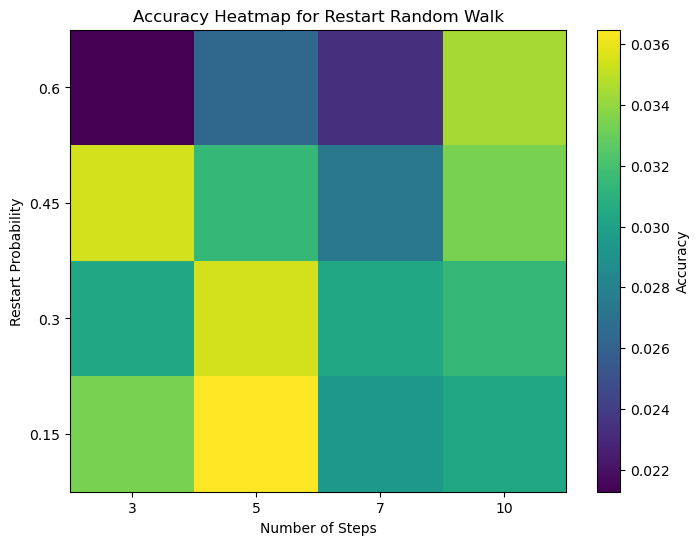

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
restart_probs_sorted = sorted(set([res[0] for res in results_restart]))
num_steps_sorted = sorted(set([res[1] for res in results_restart]))

# Create an accuracy grid
accuracy_grid = np.zeros((len(restart_probs_sorted), len(num_steps_sorted)))

# Populate the grid with accuracy values
for restart_prob, num_steps, accuracy in results_restart:
    rp_idx = restart_probs_sorted.index(restart_prob)
    ns_idx = num_steps_sorted.index(num_steps)
    accuracy_grid[rp_idx, ns_idx] = accuracy

# Plot the heatmap using imshow
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_grid, cmap="viridis", origin="lower", aspect="auto")

# Set custom tick labels for x and y axes
plt.xticks(ticks=np.arange(len(num_steps_sorted)), labels=num_steps_sorted)
plt.yticks(ticks=np.arange(len(restart_probs_sorted)), labels=restart_probs_sorted)

# Add colorbar and labels
plt.colorbar(label="Accuracy")
plt.xlabel("Number of Steps")
plt.ylabel("Restart Probability")
plt.title("Accuracy Heatmap for Restart Random Walk")
plt.show()


## Restart Random Walk Distance Metric

In [38]:
import igraph as ig
import random
import json

# Step 1: Load the graph from GraphML
# graph = ig.Graph.Read_GraphML("../network-parser/track_graph.graphml")
# graph.to_undirected()  # Ensure the graph is undirected

# random.seed(44)

# Step 2: Define the Restart Random Walk function
def restart_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, restart_prob=0.15):
    """
    Perform a restart random walk while avoiding tracks in the user's playlist ID.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        start_node (int): The starting node index for the random walk.
        user_pid (int): The user's playlist ID to exclude tracks from.
        num_steps (int): Number of steps for the random walk.
        restart_prob (float): Probability of restarting the walk at the starting node.
        
    Returns:
        list: A list of visited node indices during the random walk.
    """
    walk = [start_node]
    current_node = start_node

    for _ in range(num_steps):
        if random.random() < restart_prob:
            # Restart to the starting node
            current_node = start_node
        else:
            neighbors = graph.neighbors(current_node, mode="all")

            # Exclude neighbors associated with the user's playlist ID
            valid_neighbors = [
                neighbor for neighbor in neighbors
                #if user_pid not in map(int, graph.vs[neighbor]["playlists"].split(","))
            ]
            if not valid_neighbors:
                break  # Stop if no valid neighbors

            # Get edge weights for valid neighbors
            edge_ids = [graph.get_eid(current_node, neighbor) for neighbor in valid_neighbors]
            weights = [graph.es[edge_id]["weight"] for edge_id in edge_ids]

            current_node = random.choices(valid_neighbors, weights=weights, k=1)[0]

        walk.append(current_node)

    return walk

# Step 3: Recommendation function
def recommend_tracks_by_pid_restart(graph, user_pid, user_track, num_steps=5, top_n=1, restart_prob=0.15):
    """
    Recommend tracks based on a restart random walk avoiding tracks in the user's playlist.
    
    Args:
        graph (igraph.Graph): The input graph with edge weights.
        user_pid (int): The user's playlist ID to exclude tracks from.
        user_track (str): The track ID of the starting node.
        num_steps (int): Number of steps for the random walk.
        top_n (int): Number of recommendations to return.
        restart_prob (float): Probability of restarting the walk at the starting node.
        
    Returns:
        list: A list of recommended track IDs.
    """
    try:
        start_node = graph.vs.find(id=user_track).index
    except ValueError:
        #raise ValueError(f"Track '{user_track}' not found in the graph.")
        return None

    walk = restart_random_walk_exclude_user_pid(graph, start_node, user_pid, num_steps, restart_prob)

    visit_counts = {}
    for node in walk:
        track_id = graph.vs[node]["id"]
        #if user_pid not in map(int, graph.vs[node]["playlists"].split(",")):
        visit_counts[track_id] = visit_counts.get(track_id, 0) + 1

    recommended_tracks = sorted(visit_counts, key=visit_counts.get, reverse=True)
    eligible_tracks = [track for track in recommended_tracks if track != user_track]
    return eligible_tracks[:top_n]

# Step 4: Accuracy testing function
def calculate_and_visualize_distance_metrics_restart(graph, test_data_path, num_steps=5, top_n=1, restart_prob=1.0):
    with open(test_data_path, "r") as f:
        test_data = json.load(f)

    playlists = test_data["playlists"]
    distances = []

    for playlist in playlists:
        user_pid = playlist["pid"]
        input_track = playlist["tracks"][0]["track_uri"]  # First track in the playlist

        try:
            recommended_tracks = recommend_tracks_by_pid_restart(
                graph, user_pid, input_track, num_steps, top_n, restart_prob
            )

            if recommended_tracks:
                for recommended_track in recommended_tracks:
                    try:
                        recommended_node = graph.vs.find(id=recommended_track).index

                        # Calculate distances to all tracks in the playlist
                        # Calculate distance to playlist tracks only
                        def safe_find_vertex(graph, track_uri):
                            try:
                                return graph.vs.find(id=track_uri).index
                            except ValueError:
                                return None
                    
                        playlist_nodes = [
                            safe_find_vertex(graph, track["track_uri"])
                            for track in playlist["tracks"]
                            if track["track_uri"] != input_track
                        ]
                        playlist_nodes = [node for node in playlist_nodes if node is not None]  # Remove None entries

                        distances_to_playlist = [
                            graph.shortest_paths(recommended_node, other_node)[0][0]
                            for other_node in playlist_nodes
                        ]

                        if distances_to_playlist:
                            distances.append(min(distances_to_playlist))
                    except ValueError:
                        logger.error(f"Recommended track '{recommended_track}' not found in the graph.")

        except ValueError as e:
            logger.error(e)

    if distances:
        mean_distance = np.mean(distances)
        median_distance = np.median(distances)

        logger.info(f"Mean Distance: {mean_distance:.2f}")
        logger.info(f"Median Distance: {median_distance:.2f}")

        return mean_distance, median_distance
    else:
        logger.info("No distances to visualize.")
        return None, None


# Step 5: Run the test
test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"  # Path to your test JSON file
# test_recommendation_accuracy_restart(graph, test_data_path, restart_prob=0.15, num_steps=50, top_n=1)


In [39]:
import itertools
import random
from tqdm import tqdm

# Define parameter ranges
restart_probs = [0.15, 0.3, 0.45, 0.6]
num_steps_values = [3, 5, 7, 10]
top_n_values = 1

# Use grid search or random sampling
grid_search = True  # Set to False for random sampling
num_random_samples = 10  # Only relevant for random search

# Prepare combinations of parameters
if grid_search:
    param_combinations = list(itertools.product(restart_probs, num_steps_values))
else:
    param_combinations = [
        (
            random.choice(restart_probs),
            random.choice(num_steps_values),
        )
        for _ in range(num_random_samples)
    ]

# Best parameter tracking
best_distance = 0
best_params = None

results_restart = []
# Loop through parameter combinations
for restart_prob, num_steps in tqdm(param_combinations, desc="Parameter tuning"):
    print(f"Testing parameters: restart_prob={restart_prob}, num_steps={num_steps}")
    try:
        mean_distance, median_distance = calculate_and_visualize_distance_metrics_restart(graph, test_data_path, restart_prob=restart_prob, num_steps=num_steps, top_n=1)
        print(f"Mean Distance: {mean_distance:.4f}")

        # Update best parameters
        if mean_distance > best_distance:
            best_distance = mean_distance
            best_params = (restart_prob, num_steps)
        results_restart.append((restart_prob, num_steps, mean_distance))
    except Exception as e:
        print(f"Error with parameters restart_prob={restart_prob}, num_steps={num_steps}: {e}")

# Print the best parameters
print(f"\nBest Parameters: restart_prob={best_params[0]}, num_steps={best_params[1]}")
print(f"Best Mean Distance: {best_distance:.4f}")


Parameter tuning:   0%|                                           | 0/4 [00:00<?, ?it/s]

Testing parameters: restart_prob=0.15, num_steps=3


/var/folders/nq/b7pjjp05003dqcdxtbz9ws6w0000gn/T/ipykernel_59483/2074839168.py:126: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  graph.shortest_paths(recommended_node, other_node)[0][0]
INFO:__main__:Mean Distance: 1.00
INFO:__main__:Median Distance: 1.00
Parameter tuning:  25%|████████▊                          | 1/4 [01:15<03:45, 75.05s/it]

Mean Distance: 1.0000
Testing parameters: restart_prob=0.15, num_steps=5


INFO:__main__:Mean Distance: 1.33
INFO:__main__:Median Distance: 1.00
Parameter tuning:  50%|█████████████████▌                 | 2/4 [02:18<02:17, 68.51s/it]

Mean Distance: 1.3333
Testing parameters: restart_prob=0.3, num_steps=3


INFO:__main__:Mean Distance: 1.33
INFO:__main__:Median Distance: 1.00
Parameter tuning:  75%|██████████████████████████▎        | 3/4 [03:23<01:06, 66.83s/it]

Mean Distance: 1.3333
Testing parameters: restart_prob=0.3, num_steps=5


INFO:__main__:Mean Distance: 1.33
INFO:__main__:Median Distance: 1.50
Parameter tuning: 100%|███████████████████████████████████| 4/4 [04:28<00:00, 67.00s/it]

Mean Distance: 1.3333

Best Parameters: restart_prob=0.15, num_steps=5
Best Mean Distance: 1.3333


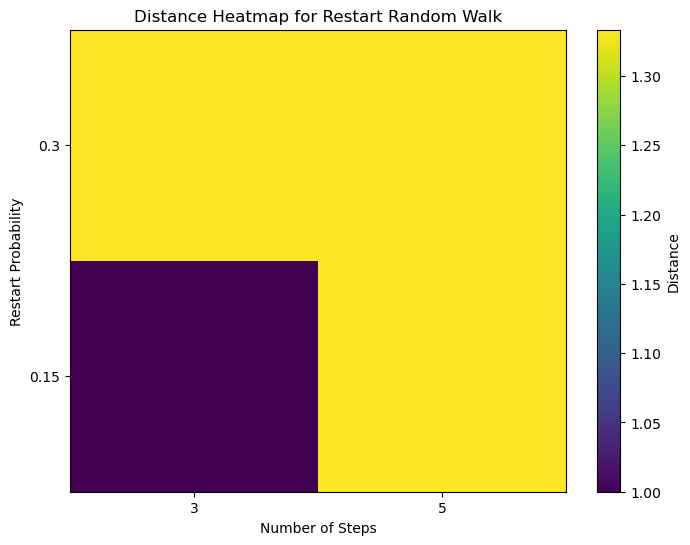

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
restart_probs_sorted = sorted(set([res[0] for res in results_restart]))
num_steps_sorted = sorted(set([res[1] for res in results_restart]))

# Create an accuracy grid
accuracy_grid = np.zeros((len(restart_probs_sorted), len(num_steps_sorted)))

# Populate the grid with accuracy values
for restart_prob, num_steps, accuracy in results_restart:
    rp_idx = restart_probs_sorted.index(restart_prob)
    ns_idx = num_steps_sorted.index(num_steps)
    accuracy_grid[rp_idx, ns_idx] = accuracy

# Plot the heatmap using imshow
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_grid, cmap="viridis", origin="lower", aspect="auto")

# Set custom tick labels for x and y axes
plt.xticks(ticks=np.arange(len(num_steps_sorted)), labels=num_steps_sorted)
plt.yticks(ticks=np.arange(len(restart_probs_sorted)), labels=restart_probs_sorted)

# Add colorbar and labels
plt.colorbar(label="Distance")
plt.xlabel("Number of Steps")
plt.ylabel("Restart Probability")
plt.title("Distance Heatmap for Restart Random Walk")
plt.show()


# Community Detection

In [24]:
import igraph as ig

# Step 1: Load the graph and ensure it's undirected
# graph = ig.Graph.Read_GraphML("../network-parser/track_graph.graphml")
# graph.to_undirected()

# Step 2: Perform community detection
communities = graph.community_multilevel()

# Step 3: Compute node degrees
degrees = graph.degree()

# Step 4: Get top nodes in each community
top_nodes_per_community = {}
for i, community in enumerate(communities):
    # Rank nodes by degree within the community
    ranked_nodes = sorted(community, key=lambda node: degrees[node], reverse=True)
    # Get top 5 nodes
    top_nodes_per_community[i] = ranked_nodes[:5]

# Step 5: Print results
print(f"Number of communities detected: {len(communities)}")
for community_id, top_nodes in top_nodes_per_community.items():
    print(f"\nTop nodes in Community {community_id}:")
    for node in top_nodes:
        print(f"  Node {graph.vs[node]['id']} with degree {degrees[node]}")


Number of communities detected: 72

Top nodes in Community 0:
  Node spotify:track:1snNAXmmPXCn0dkF9DaPWw with degree 2340
  Node spotify:track:0dPBlz8N0veeceejtuvpPz with degree 1949
  Node spotify:track:6ZT3coOj97F6CVvruPtnox with degree 1924
  Node spotify:track:0k93MXOj0kSXo84SvSDeUz with degree 1780
  Node spotify:track:6vjWim6xU6tPjA42GxSp1U with degree 1673

Top nodes in Community 1:
  Node spotify:track:2GiJYvgVaD2HtM8GqD9EgQ with degree 2950
  Node spotify:track:3ZMv9EzGoteNi5Qnx0KpEO with degree 2800
  Node spotify:track:4llK75pXNWZz6KAho2Gp16 with degree 2751
  Node spotify:track:3n69hLUdIsSa1WlRmjMZlW with degree 2597
  Node spotify:track:13HVjjWUZFaWilh2QUJKsP with degree 2573

Top nodes in Community 2:
  Node spotify:track:1tMyqN7bNCokdg7jWgKPc8 with degree 115
  Node spotify:track:1y58wFuYYnVsCnY8DsOELY with degree 115
  Node spotify:track:5ib3EGG06XUnUf7hzDnheL with degree 115
  Node spotify:track:5zLvo9lek82KN9QKRpJojD with degree 82
  Node spotify:track:7tor1N7ix61iCk

# Community based random walk

In [1]:
# specify test data
test_data_path = "/Users/horace/Downloads/data/mpd.slice.999000-999999.json"

# community detection
communities = graph.community_multilevel()

# convert communities to induced subgraph
subgraphs = [graph.induced_subgraph(community) for community in communities]

# combine subgraphs using disjoint_union
combined_graph = subgraphs[0]  # Start with first subgraph
for sg in subgraphs[1:]:
    combined_graph = combined_graph.disjoint_union(sg)

# test recommendation accuracy
calculate_and_visualize_distance_metrics(combined_graph, test_data_path, num_steps=7, top_n=1)
calculate_and_visualize_distance_metrics_node2vec(combined_graph, test_data_path, p=2, q=2, num_steps=7, top_n=1)
calculate_and_visualize_distance_metrics_restart(combined_graph, test_data_path, restart_prob=0.15, num_steps=5, top_n=1)

NameError: name 'graph' is not defined

In [34]:
calculate_and_visualize_distance_metrics(combined_graph, test_data_path, num_steps=7, top_n=1)
calculate_and_visualize_distance_metrics_node2vec(combined_graph, test_data_path, p=2, q=2, num_steps=7, top_n=1)
calculate_and_visualize_distance_metrics_restart(combined_graph, test_data_path, restart_prob=0.15, num_steps=5, top_n=1)

Testing playlists:   0%|          | 0/1000 [00:00<?, ?it/s]


Accuracy: 4.05% (40/987)
Accuracy: 3.14% (31/987)
Accuracy: 3.44% (34/987)


0.034447821681864235

In [35]:
calculate_and_visualize_distance_metrics(combined_graph, test_data_path, num_steps=7, top_n=1)
calculate_and_visualize_distance_metrics_node2vec(combined_graph, test_data_path, p=2, q=2, num_steps=7, top_n=1)
calculate_and_visualize_distance_metrics_restart(combined_graph, test_data_path, restart_prob=0.15, num_steps=5, top_n=1)

Testing playlists:   0%|          | 0/1000 [00:00<?, ?it/s]


Accuracy: 3.14% (31/987)
Accuracy: 4.86% (48/987)
Accuracy: 2.43% (24/987)


0.0243161094224924